In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 41.5MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [ ]:
import numpy as np
import pandas as pd
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# img_path = '/content/drive/My Drive/w200_s100_k25/'
# img = open_image(Path(img_path + '/6d2141c1c6593fc206e2a695cb591831.jpeg'))
# print(img.shape)
# img

In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
train[['primary Gleason', 'secondary Gleason']] = train.gleason_score.str.split('+',expand=True)
display(train.head())

train['id'] = train['image_id'] + '.jpeg'
train_isup = train[['id', 'isup_grade']]
train_primary = train[['id', 'primary Gleason']]
train_secondary = train[['id', 'secondary Gleason']]

,image_id,data_provider,isup_grade,gleason_score,primary Gleason,secondary Gleason
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,4,4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0,0


In [ ]:
# Due to the size of the images used for training we aren't able to load all the images at once
# this creates a dataframe which contains the sample of images (around 8.8k of 10.1k)

train_isup['isup_grade'] = train_isup['isup_grade'].astype(int)

# This section creates a new dataframe with bins for each grade value

train_isup['grade_1'] = pd.Series([1 if x >= 1 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_2'] = pd.Series([1 if x >= 2 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_3'] = pd.Series([1 if x >= 3 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_4'] = pd.Series([1 if x >= 4 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_5'] = pd.Series([1 if x >= 5 else 0 for x in train_isup['isup_grade']], index=train_isup.index)

train_bin = train_isup[['id', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5']]

In [ ]:
#extra_xforms=[z for z in []]
transform = get_transforms(do_flip=True,
                           flip_vert=True,#default False
                           max_rotate=15,
                           max_zoom=1.0,
                           max_lighting=0.25,
                           max_warp=0.1,
                           p_affine=0.5,
                           p_lighting = 0.5, 
                           xtra_tfms= [
                               *zoom_crop(scale=(2,2), do_rand=True),#currently not working
# ###                               rand_resize_crop(size=224, max_scale=2.0, ratios=(0.75, 1.33)), #currently not working
#                                 rotate(degrees=(-30,30), p=0.75),
#                                 brightness(change=0.5),
# ###                               contrast(scale=1),#currently not working
#                                 crop_pad(size=512, padding_mode='reflection', row_pct=1., col_pct=1.),
#                                 jitter(magnitude=0.03),
# ###                               crop(row_pct=0.5, col_pct=0.5),
#                                 pad(mode='border'),
#                                  perspective_warp(magnitude=0.03, invert=False),
#                                 rotate(degrees=0.0),
#                                 rgb_randomize(channel=None, thresh=0.3),
# ###                               skew(direction=1, magnitude=0.03, invert=False), #currently not working
#                                 squish(scale=1.1, row_pct=0.7, col_pct=0.7),
                                 symmetric_warp(magnitude=(-0.2,0.2)),
# ###                               tilt(direction=0, magnitude=0, invert=False), #currently not working
#                                  zoom(scale=2.0, row_pct=1., col_pct=1.),
#                                 cutout(n_holes=(4,12), length=(10,40))
                           ]
                          )

In [ ]:
path = Path('/content/drive/My Drive/w200_s100_k25/')
data = ImageDataBunch.from_df(path=path,
                              df=train_bin, #train_isup (the actual target), train_primary, train_secondary
                              valid_pct=0.3,
                              label_col=['grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5'],
                              size=343,
                              bs=12,
                              ds_tfms=transform
        ).normalize(imagenet_stats)

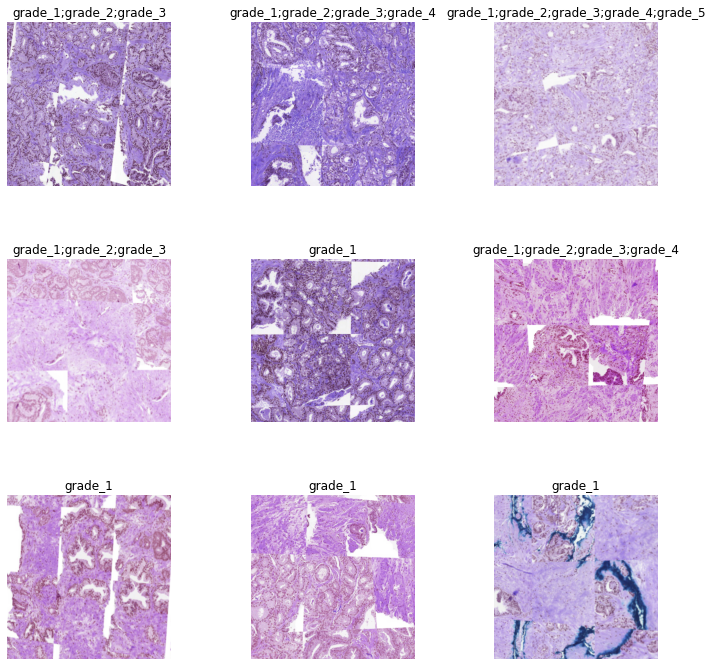

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
import torch
import torch.nn as nn
loss_func=nn.BCEWithLogitsLoss()

In [ ]:
# #!pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_name('efficientnet-b0')
# model._fc = nn.Linear(1280, data.c)
# learn = Learner(data, model, metrics=[fbeta, r2_score, explained_variance, accuracy, accuracy_thresh])
# Model_Path = Path('/kaggle/working/')
# learn.model_dir = Model_Path

In [ ]:
learn = cnn_learner(data, models.densenet169, loss_func=nn.BCEWithLogitsLoss(), metrics=[fbeta, accuracy, accuracy_thresh])
Model_Path = Path('/content/drive/My Drive')
learn.model_dir = Model_Path

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


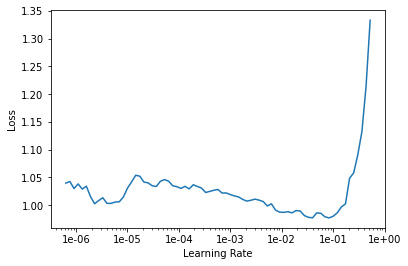

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=5e-3)

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time
0,0.509017,0.617127,0.586331,0.645100,0.739259,52:32
1,0.393831,0.440566,0.615770,0.640075,0.799560,10:54


In [ ]:
learn.save('dense169-checkpoint-1')

In [ ]:
#learn.load('vgg19-checkpoint-1');

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


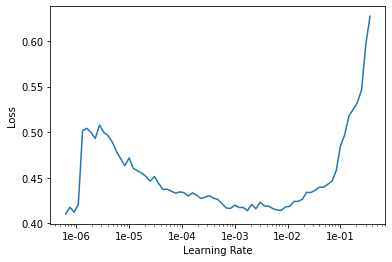

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time
0,0.414817,0.510421,0.609751,0.607035,0.767023,10:34
1,0.395077,0.435994,0.616274,0.623555,0.808731,10:37
2,0.388113,0.425398,0.616009,0.617776,0.803643,10:41
3,0.361874,0.426186,0.612550,0.626193,0.804083,10:24


In [ ]:
learn.save('dense169-checkpoint-2')

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


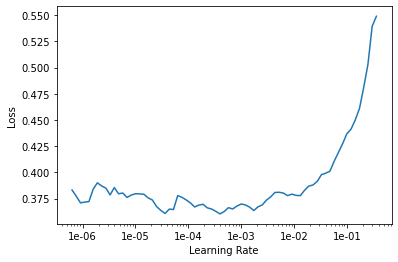

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=4e-4, wd=1e-1)

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time
0,0.365430,0.441884,0.582429,0.608919,0.803266,11:37
1,0.390456,0.407053,0.623481,0.621734,0.816018,11:53
2,0.369752,0.409580,0.621128,0.612500,0.813505,11:49


In [ ]:
learn.save('dense169-checkpoint-3')

In [ ]:
del data
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
